## Loading In - Base Results

In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from torch.optim import AdamW
pd.options.mode.chained_assignment = None
import warnings
import random
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import brier_score_loss
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN

from google.colab import drive
drive.mount('/content/drive')

games = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/games.csv")
player_play = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/player_play.csv")
players = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/players.csv")
plays = pd.read_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/plays.csv")

Mounted at /content/drive


In [ ]:
# takes roughly ~5mins to run
# -- loading in tracking data with zone/man probs

all_data = []

for week_eval in range(1,10):

  preds_week = pd.read_csv(f"/content/drive/MyDrive/nfl-big-data-bowl-2025/tracking_week_{week_eval}_preds.csv")
  all_data.append(preds_week)
  print(f"Finished processing week {week_eval}...")

all_weeks = pd.concat(all_data, ignore_index=True)
all_weeks['base_correct'] = all_weeks['pred'] == all_weeks['actual']

Finished processing week 1...
Finished processing week 2...
Finished processing week 3...
Finished processing week 4...
Finished processing week 5...
Finished processing week 6...
Finished processing week 7...
Finished processing week 8...
Finished processing week 9...


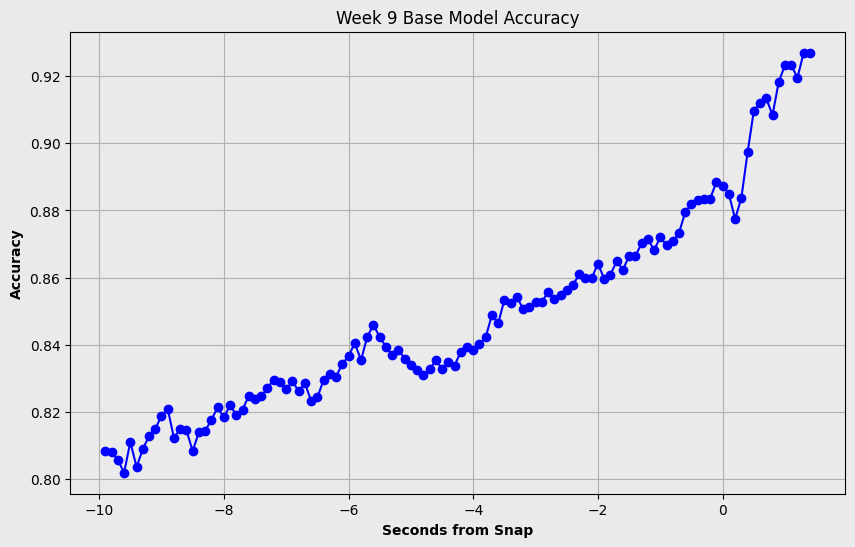

In [ ]:
# filter for right frames -- week 9 for vis

week_9_accuracy = all_weeks[(all_weeks['week'] == 9) & (all_weeks['frames_from_snap'] < 15) & (all_weeks['frames_from_snap'] > -100)]
week_9_accuracy['seconds_from_snap'] = week_9_accuracy['frames_from_snap'] / 10

accuracy_by_frame = week_9_accuracy.groupby('seconds_from_snap')['base_correct'].mean()

plt.figure(figsize=(10, 6), facecolor="#EAEAEA")
plt.plot(accuracy_by_frame.index, accuracy_by_frame.values, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Seconds from Snap', fontweight='bold')
plt.ylabel('Accuracy',fontweight='bold')
plt.title('Week 9 Base Model Accuracy')
plt.grid(True)
ax = plt.gca()
ax.set_facecolor("#EAEAEA")
plt.show()

## 0.5 second delta

In [ ]:
# rodgers to lazard thanksgiving —— 2022110603_796

# lazard = all_weeks[all_weeks['uniqueId'] == "2022110603_796"]
# animate_play(lazard)

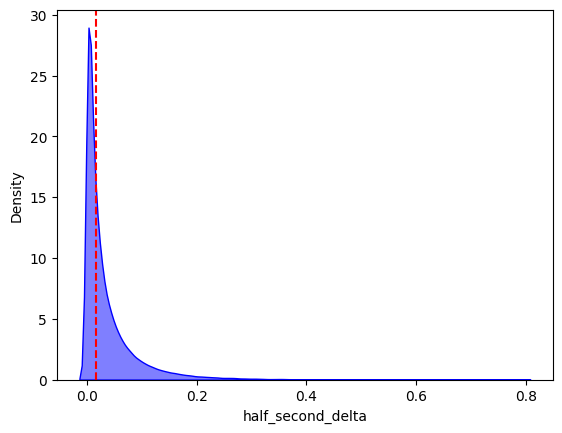

In [ ]:
all_weeks_no_dupls = all_weeks.drop_duplicates(subset='frameUniqueId', keep='first')

all_weeks_no_dupls = all_weeks_no_dupls.sort_values(by=['uniqueId', 'frameId'])
# all_weeks_no_dupls['zone_prob_delta'] = all_weeks_no_dupls.groupby('uniqueId')['zone_prob'].diff().abs()

all_weeks_no_dupls['half_second_delta'] = (all_weeks_no_dupls.groupby('uniqueId')['zone_prob'].shift(5) - all_weeks_no_dupls['zone_prob']).abs()

# all_weeks_no_dupls[(all_weeks_no_dupls['uniqueId'] == "2022090800_1030")].sort_values(by='frameId',ascending=True).head(10)[['zone_prob', 'zone_prob_delta']]

two_seconds = all_weeks_no_dupls[(all_weeks_no_dupls['frames_from_snap'] > -30) & (all_weeks_no_dupls['frames_from_snap'] < 0)]

plt.axvline(two_seconds['half_second_delta'].median(), color="red", linestyle="--", linewidth=1.5, label=f"Median: {two_seconds['half_second_delta'].median():.3f}")
sns.kdeplot(data=two_seconds, x="half_second_delta", fill=True, alpha=0.5, color="blue")
plt.show()

In [ ]:
def z_scores(two_seconds):

  data = two_seconds['half_second_delta']
  median = np.median(data)

  mad = np.median(np.abs(data - median))
  z_scores = 0.6745 * (data - median) / mad
  two_seconds['z_scores'] = z_scores

  return two_seconds

In [ ]:
two_seconds = z_scores(two_seconds)

In [ ]:
# CHANGING Z SCORE THRESHOLD

Z_SCORE_THRESHOLD = 3.5
#Z_SCORE_THRESHOLD = 5
tells = two_seconds[two_seconds['z_scores'] > Z_SCORE_THRESHOLD]

In [ ]:
print(f"From {len(set(two_seconds['uniqueId']))}")
print(f"To {len(set(tells['uniqueId']))}")

From 8615
To 3460


In [ ]:
tell_ids = set(tells['uniqueId'])
tells['moves_to_man'] = 0
tells['moves_to_zone'] = 0
tells['correct_presnap'] = 0

for tell in tell_ids:

  data = tells[tells['uniqueId'] == tell]

  min_frame = data['frameId'].min()
  max_frame = data['frameId'].max()

  min_frame_man_prob = data.loc[data['frameId'] == min_frame, 'man_prob'].iloc[0]
  max_frame_man_prob = data.loc[data['frameId'] == max_frame, 'man_prob'].iloc[0]

  correct_bool = data.loc[data['frameId'] == max_frame, 'base_correct'].iloc[0]

  if correct_bool:
    tells.loc[tells['uniqueId'] == tell, 'correct_presnap'] = 1

  if max_frame_man_prob > min_frame_man_prob:
    tells.loc[tells['uniqueId'] == tell, 'moves_to_man'] = 1
  else:
    tells.loc[tells['uniqueId'] == tell, 'moves_to_zone'] = 1

In [ ]:
tells_moving_correct = tells[
    ((tells['moves_to_man'] == 1) & (tells['actual'] == 1)) |
    ((tells['moves_to_zone'] == 1) & (tells['actual'] == 0))
]

correct_no_dupl = tells_moving_correct[tells_moving_correct['correct_presnap'] == 1]

## Identifying Players

In [ ]:
import random

ids = list(set(correct_no_dupl['uniqueId']))
id = random.choice(ids)

max_frame = correct_no_dupl[correct_no_dupl['uniqueId'] == id]['frameId'].max()
min_frame = correct_no_dupl[correct_no_dupl['uniqueId'] == id]['frameId'].min()

all_weeks[
    (all_weeks['uniqueId'] == id) &
    (all_weeks['frameId'] > max_frame - 10) & (all_weeks['frameId'] < max_frame)
    ].sort_values(by='frameId', ascending=True).drop_duplicates(subset=['frameId', 'man_prob'])[['frameId', 'man_prob', 'snap_frame']]

,frameId,man_prob,snap_frame
13772878,89,0.686191,99
13773266,90,0.679220,99
13774428,91,0.672059,99
13773526,92,0.657599,99
13772237,93,0.635756,99
13774173,94,0.611274,99
13773787,95,0.587221,99
13772369,96,0.562104,99
13773402,97,0.496214,99



*   Empirical but 1 second before the tell is a good landing spot... can keep this timing but worth optimizing in future

In [ ]:
filtered_all_weeks = all_weeks[all_weeks['uniqueId'].isin(correct_no_dupl['uniqueId'])]

ids = set(correct_no_dupl['uniqueId'])
tracking_tells = pd.DataFrame()

counter = 0

for uniqueId in ids:

  max_frame = correct_no_dupl[correct_no_dupl['uniqueId'] == uniqueId]['frameId'].max()

  ## CHANGING - MAX FRAME + 5 AND MAX_FRAME - 15
  current_tells = filtered_all_weeks[(filtered_all_weeks['uniqueId'] == uniqueId) & (filtered_all_weeks['frameId'] < max_frame + 5) & (filtered_all_weeks['frameId'] > max_frame - 15)]

  tracking_tells = pd.concat([tracking_tells, current_tells], ignore_index=True)

  counter += 1

  if counter % 100 == 0:
    print(f"Checkpoint: {counter}")

Checkpoint: 100
Checkpoint: 200
Checkpoint: 300
Checkpoint: 400
Checkpoint: 500
Checkpoint: 600
Checkpoint: 700
Checkpoint: 800
Checkpoint: 900
Checkpoint: 1000
Checkpoint: 1100
Checkpoint: 1200
Checkpoint: 1300
Checkpoint: 1400
Checkpoint: 1500
Checkpoint: 1600
Checkpoint: 1700
Checkpoint: 1800
Checkpoint: 1900


In [ ]:
# -- can modify detect_outlier function to use constrainted K-Means, DBSCAN, many others... but this is simplest

def detect_outlier(play):

  max_frame = play['frameId'].max()
  data = play[play['frameId'] == max_frame - 1]
  data = data[data['defense'] == 1]

  data['distance_from_origin'] = np.sqrt(data['v_x']**2 + data['v_y']**2)

  max_distance_row = data.loc[data['distance_from_origin'].idxmax()]

  outlier_name = max_distance_row['displayName']

  return outlier_name

In [ ]:
ids = list(set(tracking_tells['uniqueId']))
players_tells = pd.DataFrame()

for uniqueId in ids:

  play = tracking_tells[tracking_tells['uniqueId'] == uniqueId]
  outlier_name = detect_outlier(play)

  play['tellPlayerName'] = outlier_name

  players_tells = pd.concat([players_tells, play], ignore_index=True)

players_tells.to_csv("/content/drive/MyDrive/nfl-big-data-bowl-2025/players_tells_tracking.csv")